<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 4: Classification with Yelp, SGD, OOP

## Yelp

---

In this project you will be investigating a small version of the [Yelp challenge dataset](https://www.yelp.com/dataset_challenge). You'll practice using classification algorithms, cross-validation, gridsearching – all that good stuff.

---

### The data

There are 5 individual .csv files that have the information, zipped into .7z format like with the SF data last project. The dataset is located in your datasets folder:

    DSI-SF-2/datasets/yelp_arizona_data.7z

The columns in each are:

    businesses_small_parsed.csv
        business_id: unique business identifier
        name: name of the business
        review_count: number of reviews per business
        city: city business resides in
        stars: average rating
        categories: categories the business falls into (can be one or multiple)
        latitude
        longitude
        neighborhoods: neighborhoods business belongs to
        variable: "property" of the business (a tag)
        value: True/False for the property
        
    reviews_small_nlp_parsed.csv
        user_id: unique user identifier
        review_id: unique review identifier
        votes.cool: how many thought the review was "cool"
        business_id: unique business id the review is for
        votes.funny: how many thought the review was funny
        stars: rating given
        date: date of review
        votes.useful: how many thought the review was useful
        ... 100 columns of counts of most common 2 word phrases that appear in reviews in this review
        
    users_small_parsed.csv
        yelping_since: signup date
        compliments.plain: # of compliments "plain"
        review_count: # of reviews:
        compliments.cute: total # of compliments "cute"
        compliments.writer: # of compliments "writer"
        compliments.note: # of compliments "note" (not sure what this is)
        compliments.hot: # of compliments "hot" (?)
        compliments.cool: # of compliments "cool"
        compliments.profile: # of compliments "profile"
        average_stars: average rating
        compliments.more: # of compliments "more"
        elite: years considered "elite"
        name: user's name
        user_id: unique user id
        votes.cool: # of votes "cool"
        compliments.list: # of compliments "list"
        votes.funny: # of compliments "funny"
        compliments.photos: # of compliments "photos"
        compliments.funny: # of compliments "funny"
        votes.useful: # of votes "useful"
       
    checkins_small_parsed.csv
        business_id: unique business identifier
        variable: day-time identifier of checkins (0-0 is Sunday 0:00 - 1:00am,  for example)
        value: # of checkins at that time
    
    tips_small_nlp_parsed.csv
        user_id: unique user identifier
        business_id: unique business identifier
        likes: likes that the tip has
        date: date of tip
        ... 100 columns of counts of most common 2 word phrases that appear in tips in this tip

The reviews and tips datasets in particular have parsed "NLP" columns with counts of 2-word phrases in that review or tip (a "tip", it seems, is some kind of smaller review).

The user dataset has a lot of columns of counts of different compliments and votes. I'm not sure whether the compliments or votes are _by_ the user or _for_ the user.

---

If you look at the website, or the full data, you'll see I have removed pieces of the data and cut it down quite a bit. This is to simplify it for this project. Specifically, business are limited to be in these cities:

    Phoenix
    Surprise
    Las Vegas
    Waterloo

Apparently there is a city called "Surprise" in Arizona. 

Businesses are also restricted to at least be in one of the following categories, because I thought the mix of them was funny:

    Airports
    Breakfast & Brunch
    Bubble Tea
    Burgers
    Bars
    Bakeries
    Breweries
    Cafes
    Candy Stores
    Comedy Clubs
    Courthouses
    Dance Clubs
    Fast Food
    Museums
    Tattoo
    Vape Shops
    Yoga
    
---

### Project requirements

**You will be performing 4 different sections of analysis, like in the last project.**

Remember that classification targets are categorical and regression targets are continuous variables.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

plt.style.use('fivethirtyeight')


from ipywidgets import *
from IPython.display import display

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Constructing a "profile" for Las Vegas

---

Yelp is interested in building out what they are calling "profiles" for cities. They want you to start with just Las Vegas to see what a prototype of this would look like. Essentially, they want to know what makes Las Vegas distinct from the other four.

Use the data you have to predict Las Vegas from the other variables you have. You should not be predicting the city from any kind of location data or other data perfectly associated with that city (or another city).

You may use any classification algorithm you deem appropriate, or even multiple models. You should:

1. Build at least one model predicting Las Vegas vs. the other cities.
- Validate your model(s).
- Interpret and visualize, in some way, the results.
- Write up a "profile" for Las Vegas. This should be a writeup converting your findings from the model(s) into a human-readable description of the city.

In [2]:
business = pd.read_csv('/Users/Gene/Desktop/gzdsi7/datasets/yelp_arizona_data/businesses_small_parsed.csv')
checkins = pd.read_csv('/Users/Gene/Desktop/gzdsi7/datasets/yelp_arizona_data/checkins_small_parsed.csv')
reviews = pd.read_csv('/Users/Gene/Desktop/gzdsi7/datasets/yelp_arizona_data/reviews_small_nlp_parsed.csv')
tips = pd.read_csv('/Users/Gene/Desktop/gzdsi7/datasets/yelp_arizona_data/tips_small_nlp_parsed.csv')
users = pd.read_csv('/Users/Gene/Desktop/gzdsi7/datasets/yelp_arizona_data/users_small_parsed.csv')

In [3]:
print business.shape
print business.columns


(152832, 11)
Index([u'business_id', u'name', u'review_count', u'city', u'stars',
       u'categories', u'latitude', u'longitude', u'neighborhoods', u'variable',
       u'value'],
      dtype='object')


In [4]:
import itertools

categories = business.categories.apply(eval)
business_copy = business.copy()
business_copy['categories'] = categories
unique_categories = set(list(itertools.chain(*categories.tolist())))

In [5]:
#simplified list of categories
given_cats = ['Airports', 'Breakfast & Brunch', 'Bubble Tea', 'Burgers', 'Bars', 'Bakeries', 'Breweries',
             'Cafes', 'Candy Stores', 'Comedy Clubs', 'Courthouses', 'Dance Clubs', 'Fast Food', 
             'Museums', 'Tattoo', 'Vape Shops', 'Yoga']

    
for cat in given_cats:
    business_copy[cat] = business_copy['categories'].apply(lambda x: cat in x)



In [6]:
print tips.shape, tips.columns

(101991, 104) Index([u'user_id', u'business_id', u'likes', u'date', u'24 hours',
       u'amazing food', u'animal style', u'awesome food', u'awesome place',
       u'awesome service',
       ...
       u'service good', u'service great', u'slow service', u'staff friendly',
       u'staff great', u'steak eggs', u'super friendly', u'sweet potato',
       u'velvet pancakes', u'worth wait'],
      dtype='object', length=104)


In [7]:
print reviews.columns, reviews.shape


Index([u'user_id', u'review_id', u'votes.cool', u'business_id', u'votes.funny',
       u'stars', u'date', u'votes.useful', u'10 minutes', u'15 minutes',
       ...
       u'service great', u'staff friendly', u'super friendly', u'sweet potato',
       u'tasted like', u'time vegas', u'try place', u've seen', u've tried',
       u'wait staff'],
      dtype='object', length=108) (322398, 108)


In [8]:
print users.shape, users.columns

(144206, 21) Index([u'yelping_since', u'compliments.plain', u'review_count',
       u'compliments.cute', u'compliments.writer', u'fans',
       u'compliments.note', u'compliments.hot', u'compliments.cool',
       u'compliments.profile', u'average_stars', u'compliments.more', u'elite',
       u'name', u'user_id', u'votes.cool', u'compliments.list', u'votes.funny',
       u'compliments.photos', u'compliments.funny', u'votes.useful'],
      dtype='object')


In [9]:
business_copy.columns

Index([u'business_id', u'name', u'review_count', u'city', u'stars',
       u'categories', u'latitude', u'longitude', u'neighborhoods', u'variable',
       u'value', u'Airports', u'Breakfast & Brunch', u'Bubble Tea', u'Burgers',
       u'Bars', u'Bakeries', u'Breweries', u'Cafes', u'Candy Stores',
       u'Comedy Clubs', u'Courthouses', u'Dance Clubs', u'Fast Food',
       u'Museums', u'Tattoo', u'Vape Shops', u'Yoga'],
      dtype='object')

In [10]:
for c in business_copy.city.unique():   
    business_copy[c] = business_copy['city'].apply(lambda x: c in x)

In [11]:
business_copy.columns

Index([u'business_id', u'name', u'review_count', u'city', u'stars',
       u'categories', u'latitude', u'longitude', u'neighborhoods', u'variable',
       u'value', u'Airports', u'Breakfast & Brunch', u'Bubble Tea', u'Burgers',
       u'Bars', u'Bakeries', u'Breweries', u'Cafes', u'Candy Stores',
       u'Comedy Clubs', u'Courthouses', u'Dance Clubs', u'Fast Food',
       u'Museums', u'Tattoo', u'Vape Shops', u'Yoga', u'Phoenix', u'Surprise',
       u'Las Vegas', u'Waterloo'],
      dtype='object')

In [12]:
business_copy['city'].unique()

array(['Phoenix', 'Surprise', 'Las Vegas', 'Waterloo'], dtype=object)

In [13]:
bus_bool = []
for column in business_copy:
    if business_copy[column].dtype == bool:
        bus_bool.append(column)

In [14]:
for col in bus_bool:
    business_copy[col] = business_copy[col].astype(int)

In [15]:
y = business_copy['Las Vegas']

In [16]:
X = business_copy.drop(['Las Vegas','Phoenix','Surprise','Waterloo','latitude', 'longitude'], axis=1)

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import scale, MinMaxScaler, normalize


/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [18]:
X = X._get_numeric_data()

In [19]:
X.columns

Index([u'review_count', u'stars', u'Airports', u'Breakfast & Brunch',
       u'Bubble Tea', u'Burgers', u'Bars', u'Bakeries', u'Breweries', u'Cafes',
       u'Candy Stores', u'Comedy Clubs', u'Courthouses', u'Dance Clubs',
       u'Fast Food', u'Museums', u'Tattoo', u'Vape Shops', u'Yoga'],
      dtype='object')

In [22]:
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=.8)


In [23]:
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score 
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score

In [5]:
from sklearn.linear_model import LogisticRegression, LinearRegression


In [28]:
lr = LogisticRegression(penalty='l2')

scores = cross_val_score(lr, X, y, cv=10, n_jobs=-1)
print "Cross validated accuracy scores: \n" + str(scores)

Cross validated accuracy scores: 
[ 0.62961267  0.63007066  0.62791154  0.63013609  0.62625139  0.62677485
  0.6315514   0.62343781  0.62714304  0.62943332]


In [29]:
np.mean(scores)

0.62823227668261383

In [30]:
lr.fit(x_train, y_train)
y_pred1 = lr.predict(x_test)


In [31]:
print "Logistic Regression"
print "Accuracy: " + str(accuracy_score(y_test, y_pred1))
print "Precision: " + str(precision_score(y_test, y_pred1))
print "Recall: " + str(recall_score(y_test, y_pred1))
print "F1 Score: " + str(f1_score(y_test, y_pred1))

Logistic Regression
Accuracy: 0.630320280041
Precision: 0.635717151089
Recall: 0.930053886784
F1 Score: 0.755220518153


In [20]:
rf = RandomForestClassifier()

score_rf = cross_val_score(rf, X, y, cv=10, n_jobs=-1)

In [21]:
np.mean(score_rf)

0.87819957257311343

In [25]:
print "Random Forest Classifier"
print "Accuracy: " + str(accuracy_score(y_test, y_pred))
print "Precision: " + str(precision_score(y_test, y_pred))
print "Recall: " + str(recall_score(y_test, y_pred))
print "F1 Score: " + str(f1_score(y_test, y_pred))

Random Forest Classifier
Accuracy: 0.873687309844
Precision: 0.882295519934
Recall: 0.916235394547
F1 Score: 0.898945219462


In [26]:
feature_importance = sorted(zip(rf.feature_importances_, X.columns), reverse=True)
feature_importance

[(0.81767764413728605, 'review_count'),
 (0.099890893805143849, 'stars'),
 (0.016899776894831086, 'Breakfast & Brunch'),
 (0.011288554576597864, 'Bars'),
 (0.01088168133305626, 'Burgers'),
 (0.0077392147686495107, 'Fast Food'),
 (0.0074874031574310978, 'Cafes'),
 (0.0063590646476944911, 'Dance Clubs'),
 (0.0059695405894924173, 'Bakeries'),
 (0.0031252486525033306, 'Comedy Clubs'),
 (0.0022975207411479542, 'Vape Shops'),
 (0.0021701226101657999, 'Tattoo'),
 (0.0021363458337826675, 'Bubble Tea'),
 (0.0018558362686091495, 'Breweries'),
 (0.0014070346369369087, 'Yoga'),
 (0.0013278313867024127, 'Candy Stores'),
 (0.0011183554577522386, 'Museums'),
 (0.00028467651796733009, 'Airports'),
 (8.3253984249525372e-05, 'Courthouses')]

In [32]:
dummies = (pd.get_dummies(business_copy["variable"]))
temp = pd.merge(X, dummies, left_index=True, right_index=True)

In [33]:
temp = temp.astype(float)

In [34]:
rf = RandomForestClassifier()

score_rf2 = cross_val_score(rf, temp, y, cv=10, n_jobs=-1)

In [35]:
np.mean(score_rf2)

0.8254881933872753

In [36]:
scaled = temp.apply(lambda x: MinMaxScaler(feature_range=(0,1)).fit_transform(x));

/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has 

In [37]:
rf = RandomForestClassifier()

score_rf3 = cross_val_score(rf, scaled, y, cv=10, n_jobs=-1)

In [38]:
np.mean(score_rf3)

0.82541621713333257

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Different categories of ratings

---

Yelp is finally ready to admit that their rating system sucks. No one cares about the ratings, they just use the site to find out what's nearby. The ratings are simply too unreliable for people. 

Yelp hypothesizes that this is, in fact, because different people tend to give their ratings based on different things. They believe that perhaps some people always base their ratings on quality of food, others on service, and perhaps other categories as well. 

1. Do some users tend to talk about service more than others in reviews/tips? Divide up the tips/reviews into more "service-focused" ones and those less concerned with service.
2. Create two new ratings for businesses: ratings from just the service-focused reviews and ratings from the non-service reviews.
3. Construct a regression model for each of the two ratings. They should use the same predictor variables (of your choice). 
4. Validate the performance of the models.
5. Do the models coefficients differ at all? What does this tell you about the hypothesis that there are in fact two different kinds of ratings?

In [4]:
print tips.shape, reviews.shape

(101991, 104) (322398, 108)


In [ ]:
#Do some users tend to talk about service more than others in reviews/tips? 
#Divide up the tips/reviews into more "service-focused" ones and those less concerned with service.
as we can see there are three times the amount of users in reviews than in tips

In [62]:
temp_list = []
for column in reviews.columns:
    if column in tips.columns:
        temp_list.append(column)

In [64]:
new = pd.merge(reviews,tips, on= temp_list)



In [69]:
for column in new.columns:
    print column


user_id
review_id
votes.cool
business_id
votes.funny
stars
date
votes.useful
10 minutes
15 minutes
20 minutes
30 minutes
bar food
beer selection
best ve
bloody mary
bottle service
chicken waffles
customer service
dance floor
decided try
definitely come
definitely recommend
didn want
don know
don like
don think
don want
eggs benedict
fast food
feel like
felt like
fish chips
food amazing
food came
food delicious
food good
food great
food just
food service
french fries
french toast
friday night
fried chicken
friendly staff
good food
good place
good service
good thing
good time
great atmosphere
great experience
great food
great place
great service
great time
happy hour
hash browns
highly recommend
hip hop
ice cream
just like
just ok
just right
las vegas
late night
like place
little bit
long time
looked like
looks like
love place
mac cheese
make sure
mashed potatoes
medium rare
minutes later
new york
onion rings
place good
place great
place just
potato fries
pretty good
quality food
really 

In [78]:
service_reviews = []
for column in new.columns:
    if 'service' in column:
        service_reviews.append(column)
    elif 'experience' in column:
        service_reviews.append(column)
    elif 'staff' in column:
        service_reviews.append(column)
    elif 'time' in column:
        service_reviews.append(column)
    elif 'minutes' in column:
        service_reviews.append(column)
    elif 'friendly' in column:
        service_reviews.append(column)
    elif 'sure' in column:
        service_reviews.append(column)
    elif 'right' in column:
        service_reviews.append(column)
    
    
        

In [80]:
serviced = new[service_reviews]

In [83]:
for i, c in enumerate(serviced):
     serviceddf = serviced[(serviced.T != 0).any()]

In [85]:
service_index = serviceddf.index.tolist()

In [87]:
service_index = reviews.iloc[service_index]

In [92]:
service_index.head(2)

,user_id,review_id,votes.cool,business_id,votes.funny,stars,date,votes.useful,10 minutes,15 minutes,...,service great,staff friendly,super friendly,sweet potato,tasted like,time vegas,try place,ve seen,ve tried,wait staff
8,8leVoQakIF9OfyikF7Yu5g,WwWdhzdTyef9vFBIQhm1Pw,0,EmzaQR5hQlF0WIl24NxAZA,1,1,2013-02-16,4,0,0,...,0,0,0,0,0,0,0,0,0,0
15,a41H3s3wXKFZ0CmC3Rw1bg,UPIhmDaPO63o0vYguOBgXw,0,EmzaQR5hQlF0WIl24NxAZA,0,1,2014-02-10,6,0,0,...,0,0,0,0,0,0,0,0,0,0


In [93]:
excluded = new.index.isin(service_reviews)

In [96]:
not_service = new[~excluded]

In [97]:
not_service

,user_id,review_id,votes.cool,business_id,votes.funny,stars,date,votes.useful,10 minutes,15 minutes,...,nom nom,open 24,place awesome,place eat,prime rib,slow service,staff great,steak eggs,velvet pancakes,worth wait
0,trdsekNRD-gIs50EBrScwA,XFJ7N6UDMwCUR-WvFzADPg,0,EmzaQR5hQlF0WIl24NxAZA,0,4,2012-02-27,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,zZ3V6qPihaKEIZiME1ZeeA,9blg-1OwnIWhnvp3L5gSdw,0,e5kc0CQ4R-PCCDgb274gSg,0,4,2012-12-08,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,KOTS0wdQOBCd4zEEufsmvw,xZZ93kvnOd_UAAN7qenjMQ,1,e5kc0CQ4R-PCCDgb274gSg,0,3,2013-12-31,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,b7WSqKgL8FhOZwb8yUOetQ,4q6INfYaZYrDB-8lOKMaxA,0,e5kc0CQ4R-PCCDgb274gSg,0,5,2014-06-10,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,U-7bw2PW3QDiWxjdqOtLZA,biHL-MS1uQwt_QykJoCVhg,0,72N6TdH5MdUWE2YhYRbyxw,0,2,2013-11-15,2,0,0,...,0,0,0,0,0,0,0,0,0,0
5,m4jQ8mdN5tnt4ENgzHwMrw,esOmGzBe5fpooT9rVPM70w,1,SG_gEmEXL4ID6RAEinC5Bg,0,3,2014-07-13,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,AHEjsbiM-I3if_qbEa9eeQ,J2V8rj7GRny86H6UgJd95Q,0,45puCRQ6Vh_IIAy7kkfFDQ,0,2,2014-04-21,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7,erF6siBHVsD4bJTMAmaneQ,WgO1SsfO6rDPnFyJcuC4IA,0,45puCRQ6Vh_IIAy7kkfFDQ,0,4,2014-08-26,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,G791hjE_CQ-RKiKAiB8cAQ,NTSlG_IWufdD9Wuj7XgipA,0,P7wKlbSRsoRrfH3DFOY08A,0,5,2015-10-21,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,uJmhtw96vwvggofqzJyi4A,Gk6b1wfwOBEprxHyP4Vt2Q,2,qsWxbgQwuomXvMseg23DGg,1,3,2015-03-01,3,0,0,...,0,0,0,0,0,0,0,0,0,0


In [109]:
user_service = pd.DataFrame(service_index.groupby(['user_id'])['stars'].mean()).reset_index()

In [108]:
user_not = pd.DataFrame(not_service.groupby(['user_id'])['stars'].mean()).reset_index()

In [112]:
user_ratings = pd.merge(user_service, user_not, how='inner', on='user_id')

In [115]:
user_ratings.rename(columns={"stars_x":"service",'stars_y':'not service'}, inplace=True)

In [118]:
user_ratings.head(3)

,user_id,service,not service
0,-ZWUL1xfFP-WA9iS87S8hQ,1.0,2.0
1,0Yrlfu8-YtHn2k3wr2_wGw,4.0,4.0
2,0o0VMEJeQY0pAAZ9nxErBA,4.0,5.0


In [126]:
user_ratings.pivot_table(values = ('service','not service'),index = 'user_id', margins=True).reset_index().tail(1)

,user_id,not service,service
53,All,3.575472,3.440252


In [128]:
bus_service = pd.DataFrame(service_index.groupby(['business_id'])['stars'].mean()).reset_index()

In [129]:
bus_not = pd.DataFrame(not_service.groupby(['business_id'])['stars'].mean()).reset_index()

In [134]:
bus_ratings = pd.merge(bus_service, bus_not, how='inner', on='business_id')

In [136]:
bus_ratings.rename(columns={"stars_x":"service",'stars_y':'not service'}, inplace=True)

In [137]:
bus_ratings.head(3)

,business_id,service,not service
0,0De3TQ_uSOXwgduKL0va3w,4.000000,2.00
1,3CSaqRNvYg7ZdN2zwxwzVw,4.058824,5.00
2,3UMcsN9IjoeV8JZvC4apag,3.666667,4.75


In [138]:
bus_ratings.pivot_table(values = ('service','not service'),index = 'business_id', margins=True).reset_index().tail(1)

,business_id,not service,service
29,All,3.352299,3.36303


In [144]:
for col in service_index.columns:
    print col

user_id
review_id
votes.cool
business_id
votes.funny
stars
date
votes.useful
10 minutes
15 minutes
20 minutes
30 minutes
bar food
beer selection
best ve
bloody mary
bottle service
chicken waffles
customer service
dance floor
decided try
definitely come
definitely recommend
didn want
don know
don like
don think
don want
eggs benedict
fast food
feel like
felt like
fish chips
food amazing
food came
food delicious
food good
food great
food just
food service
french fries
french toast
friday night
fried chicken
friendly staff
good food
good place
good service
good thing
good time
great atmosphere
great experience
great food
great place
great service
great time
happy hour
hash browns
highly recommend
hip hop
ice cream
just like
just ok
just right
las vegas
late night
like place
little bit
long time
looked like
looks like
love place
mac cheese
make sure
mashed potatoes
medium rare
minutes later
new york
onion rings
place good
place great
place just
potato fries
pretty good
quality food
really 

In [155]:
service_test_x = service_index.drop(['user_id','review_id','business_id','date','stars'], axis = 1)

In [159]:
service_test_y = service_index['stars'].values

In [160]:
x_train_st, x_test_st, y_train_st, y_test_st = train_test_split(service_test_x, service_test_y, train_size=.8)


In [161]:
lr = LinearRegression()

In [162]:
cross_val_score(lr, service_test_x, service_test_y, cv=3).mean()

/anaconda/envs/dsi/lib/python2.7/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


-0.18283037432133606

In [163]:
not_test_x = not_service.drop(['user_id','review_id','business_id','date','stars'], axis = 1)

In [164]:
not_test_y = not_service['stars'].values

In [165]:
x_train_nt, x_test_nt, y_train_nt, y_test_nt = train_test_split(not_test_x, not_test_y, train_size=.8)


In [166]:
cross_val_score(lr, not_test_x, not_test_y, cv=3).mean()

0.13021680771336844

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. Identifying "elite" users

---

Yelp, though having their own formula for determining whether a user is elite or not, is interested in delving deeper into what differentiates an elite user from a normal user at a broader level.

Use a classification model to predict whether a user is elite or not. Note that users can be elite in some years and not in others.

1. What things predict well whether a user is elite or not?
- Validate the model.
- If you were to remove the "counts" metrics for users (reviews, votes, compliments), what distinguishes an elite user, if anything? Validate the model and compare it to the one with the count variables.
- Think of a way to visually represent your results in a compelling way.
- Give a brief write-up of your findings.


In [7]:
users.shape

(144206, 21)

In [8]:
users.head(1)

,yelping_since,compliments.plain,review_count,compliments.cute,compliments.writer,fans,compliments.note,compliments.hot,compliments.cool,compliments.profile,...,compliments.more,elite,name,user_id,votes.cool,compliments.list,votes.funny,compliments.photos,compliments.funny,votes.useful
0,2004-10,959.0,1274,206.0,327.0,1179,611.0,1094.0,1642.0,116.0,...,134.0,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",Jeremy,rpOyqD_893cqmDAtJLbdog,11093,38.0,7681,330.0,580.0,14199


In [9]:
users['yelp_since'] = users['yelping_since'].str[:4]


In [10]:
users['yelp_since'] = users['yelp_since'].astype(float)

In [11]:
users['elite_or_not'] = users['elite'].apply(lambda x: 0 if x == '[]' else 1)

In [12]:
users = users.drop(['yelping_since','elite'], axis =1)

In [13]:
users.head(3)

,compliments.plain,review_count,compliments.cute,compliments.writer,fans,compliments.note,compliments.hot,compliments.cool,compliments.profile,average_stars,...,name,user_id,votes.cool,compliments.list,votes.funny,compliments.photos,compliments.funny,votes.useful,yelp_since,elite_or_not
0,959.0,1274,206.0,327.0,1179,611.0,1094.0,1642.0,116.0,3.66,...,Jeremy,rpOyqD_893cqmDAtJLbdog,11093,38.0,7681,330.0,580.0,14199,2004.0,1
1,89.0,442,23.0,24.0,100,83.0,101.0,145.0,9.0,3.60,...,Michael,4U9kSBLuBDU391x6bxU-YA,732,4.0,908,24.0,120.0,1483,2004.0,1
2,2.0,66,2.0,2.0,4,1.0,1.0,1.0,NaN,3.80,...,Katherine,SIBCL7HBkrP4llolm4SC2A,13,NaN,11,NaN,NaN,34,2004.0,1


In [14]:
users_copy = users.copy()

In [15]:
null_cols = []
for col in users_copy.columns:
    if 'compliments' in col:
        null_cols.append(col)

In [16]:
for col in null_cols:
    users_copy[col].fillna(np.mean(users_copy[col]), inplace=True)

In [17]:
users_copy.isnull().sum()

compliments.plain      0
review_count           0
compliments.cute       0
compliments.writer     0
fans                   0
compliments.note       0
compliments.hot        0
compliments.cool       0
compliments.profile    0
average_stars          0
compliments.more       0
name                   0
user_id                0
votes.cool             0
compliments.list       0
votes.funny            0
compliments.photos     0
compliments.funny      0
votes.useful           0
yelp_since             0
elite_or_not           0
dtype: int64

In [18]:
users_copy.dtypes

compliments.plain      float64
review_count             int64
compliments.cute       float64
compliments.writer     float64
fans                     int64
compliments.note       float64
compliments.hot        float64
compliments.cool       float64
compliments.profile    float64
average_stars          float64
compliments.more       float64
name                    object
user_id                 object
votes.cool               int64
compliments.list       float64
votes.funny              int64
compliments.photos     float64
compliments.funny      float64
votes.useful             int64
yelp_since             float64
elite_or_not             int64
dtype: object

In [19]:
for col in users_copy.columns:
    print col

compliments.plain
review_count
compliments.cute
compliments.writer
fans
compliments.note
compliments.hot
compliments.cool
compliments.profile
average_stars
compliments.more
name
user_id
votes.cool
compliments.list
votes.funny
compliments.photos
compliments.funny
votes.useful
yelp_since
elite_or_not


In [20]:
users_copy.head(1)

,compliments.plain,review_count,compliments.cute,compliments.writer,fans,compliments.note,compliments.hot,compliments.cool,compliments.profile,average_stars,...,name,user_id,votes.cool,compliments.list,votes.funny,compliments.photos,compliments.funny,votes.useful,yelp_since,elite_or_not
0,959.0,1274,206.0,327.0,1179,611.0,1094.0,1642.0,116.0,3.66,...,Jeremy,rpOyqD_893cqmDAtJLbdog,11093,38.0,7681,330.0,580.0,14199,2004.0,1


In [21]:
X = users_copy.drop(['name','user_id','elite_or_not'], axis = 1)

In [22]:
X = X.apply(lambda x: MinMaxScaler(feature_range=(0,1)).fit_transform(x))

/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has 

In [23]:
y = users_copy['elite_or_not'].values

In [6]:
from sklearn.ensemble import RandomForestClassifier

In [25]:
rf = RandomForestClassifier()

scores_rf = cross_val_score(rf, X, y, cv=10, n_jobs=-1)
print scores_rf.mean()

0.956569056444


In [26]:
x_train, x_test, y_train, y_test = train_test_split(X, y)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
print "Accuracy: " + str(accuracy_score(y_test, y_pred))
print "Precision: " + str(precision_score(y_test, y_pred))
print "Recall: " + str(recall_score(y_test, y_pred))
print "F1 Score: " + str(f1_score(y_test, y_pred))

Accuracy: 0.95789415289
Precision: 0.83956219968
Recall: 0.774249138355
F1 Score: 0.805584016393


In [27]:
feat_imp = sorted(zip(rf.feature_importances_, X), reverse=True)
feat_imp

[(0.22296080037643584, 'votes.cool'),
 (0.19060799918848711, 'review_count'),
 (0.1663148208747614, 'votes.useful'),
 (0.079760139445821471, 'votes.funny'),
 (0.047560957640047731, 'compliments.writer'),
 (0.044637752668421668, 'compliments.hot'),
 (0.040685820406340466, 'fans'),
 (0.035378270483032971, 'average_stars'),
 (0.032415556626355979, 'compliments.profile'),
 (0.030324011248676962, 'compliments.cool'),
 (0.027995063412427985, 'compliments.note'),
 (0.020209606837335432, 'yelp_since'),
 (0.019254133746458221, 'compliments.plain'),
 (0.012949261694838945, 'compliments.funny'),
 (0.010538955758597573, 'compliments.more'),
 (0.0089497562535133125, 'compliments.photos'),
 (0.0058685012805199301, 'compliments.cute'),
 (0.0035885920579269365, 'compliments.list')]

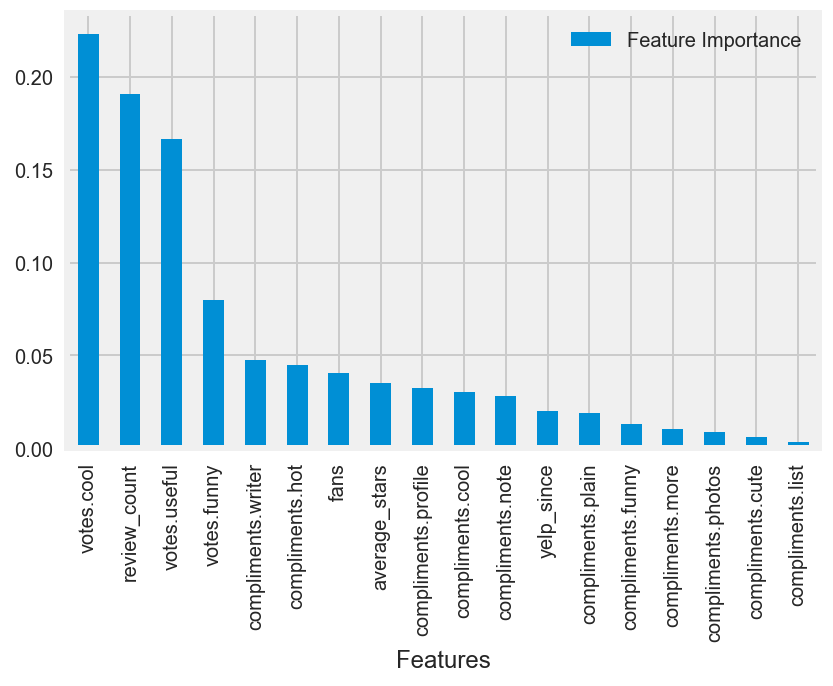

In [28]:
pd.DataFrame(feat_imp, columns = ['Feature Importance','Features']).plot(kind='bar', x ='Features')

In [29]:
dummified_users = pd.get_dummies(users_copy['name'])

In [31]:
temp = users_copy.drop('name', axis = 1)

In [32]:
temp = temp[['fans','yelp_since']]

In [34]:
dummy_temp = pd.merge(temp, dummified_users, left_index = True, right_index = True)

In [ ]:
#dummy_temp = dummy_temp.apply(lambda x: MinMaxScaler(feature_range=(0,1)).fit_transform(x))

In [35]:
x2 = dummy_temp

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 4. Find something interesting on your own

---

You want to impress your superiors at Yelp by doing some investigation into the data on your own. You want to do classification, but you're not sure on what.

1. Create a hypothesis or hypotheses about the data based on whatever you are interested in, as long as it is predicting a category of some kind (classification).
2. Explore the data visually (ideally related to this hypothesis).
3. Build one or more classification models to predict your target variable. **Your modeling should include gridsearching to find optimal model parameters.**
4. Evaluate the performance of your model. Explain why your model may have chosen those specific parameters during the gridsearch process.
5. Write up what the model tells you. Does it validate or invalidate your hypothesis? Write this up as if for a non-technical audience.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 5. ROC and Precision-recall

---

Some categories have fewer overall businesses than others. Choose two categories of businesses to predict, one that makes your proportion of target classes as even as possible, and another that has very few businesses and thus makes the target varible imbalanced.

1. Create two classification models predicting these categories. Optimize the models and choose variables as you see fit.
- Make confusion matrices for your models. Describe the confusion matrices and explain what they tell you about your models' performance.
- Make ROC curves for both models. What do the ROC curves describe and what do they tell you about your model?
- Make Precision-Recall curves for the models. What do they describe? How do they compare to the ROC curves?
- Explain when Precision-Recall may be preferable to ROC. Is that the case in either of your models?

## OOP, Stochastic Gradient Descent, and Linear Algebra

---

In this part of the project, you will implement machine learning algorithms we have covered in class from scratch. 

--- 

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 6. Implement the `LinearRegrssion` class using Stochastic Gradient Descent to include the following: 

- An option to regularize the model with Ridge Regression. The method should automatically calculate the best `alpha` for the user. The closed form solution for Ridge Regression may be helpful [Hint: Think of the `n_alphas` parameter in sklearn]


Protip: Compare if your implemenation works by applying it on the Diabetes Dataset and seeing it how it compares to opensource implemenations in `sklearn` and `statsmodels`. 

http://statsmodels.sourceforge.net/devel/examples/#regression

http://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 7. Extend the Binary `LogisticRegression` model to implement Multi-class classification that fits the model using Stochastic Gradient Descent. Include the following : 

- Use the program we coded in class that implemented Logistic regression for Binary classification and extend it to implement Multi-class classification 
  - [Binary Logistic regression program](https://github.com/ga-students/DSI-SF-5/blob/master/curriculum/week-04/logistic_regression/Logistic_regression.py)

- An option to regularize the model with Ridge Regression. The method should automatically calculate the best `alpha` for the user. The closed form solution for Ridge Regression may be helpful [Hint: Think of the `n_alphas` parameter in sklear

Check if the results of your `LogisticRegression` implementation matches with the Sklearn implementation: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">
### 8. Singular Value Decomposition 

- Read articles on image compression with SVD and use `numpy` apply it to images from the MNIST Datasets. To get the MNIST Datset, use the following comands. Note that the `mnist` data has shape `(70000, 784)`. You will need to convert it to 28x28 images [Hint: `np.reshape`]. 
       
       from sklearn.datasets import fetch_mldata
       mnist = fetch_mldata('MNIST original', data_home=custom_data_home)

    https://inst.eecs.berkeley.edu/~ee127a/book/login/l_svd_apps_image.html

    http://www.frankcleary.com/svdimage/
    
    
- Apply Logistic Regression to classify MNIST Images. This may require having the images be `784` dimensions rather than `28x28`. Compare results of the classifier on a test set when you apply it on the raw dataset vs. the compressed version of dataset from SVD. 

## Optional: Interview Practice

## Probability  and Statistics Questions 

- In any 15-minute interval, there is a 20% probability that you will see at least one shooting star. What is the probability that you see at least one shooting star in the period of an hour?


- A certain couple tells you that they have two children, at least one of which is a girl. What is the probability that they have two girls?


## Interview Questions Related to Material

- Explain what is bias-variance tradeoff to a non-technical person. Why is it a useful framework? How do you detect bias in your models? How about you variance? 


- Explain why cross-validation is important. 


- What is regularization? What are the advantages/disadvantages of different types of regularization schemes? 


- What are the loss functions associated with linear regression, logistic regression, and KNN? 


- Can you give examples of feature engineering on datasets you have worked with? 